# import all required libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from keras.datasets import cifar10
from keras.utils import to_categorical
 
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from sklearn.cluster import KMeans
from keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.regularizers import l2

# load dataset

In [55]:
# loading the dataset from https://www.cs.toronto.edu/~kriz/cifar.html using keras
(trainX, trainY), (testX, testY) = cifar10.load_data()

# EDA

In [56]:
print('Training data shape: ', trainX.shape)
print('Test data shape: ', testX.shape)
print('Number of classes: ', len(np.unique(trainY)))

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Number of classes:  10


In [57]:
# Explore the data shapes
print("Training labels shape:", trainY.shape)
print("Test labels shape:", testY.shape)

Training labels shape: (50000, 1)
Test labels shape: (10000, 1)


In [58]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [59]:
unique_train, counts_train = np.unique(trainY, return_counts=True)
print("\nTraining class distribution:")
print(dict(zip(unique_train, counts_train)))


Training class distribution:
{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [60]:
class_distribution = dict(zip(unique_train, counts_train))
class_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
class_df['Class'] = class_df['Class'].map({k: label_names[k] for k in class_distribution.keys()})

In [61]:
class_df.head(10)

,Class,Count
0,airplane,5000
1,automobile,5000
2,bird,5000
3,cat,5000
4,deer,5000
5,dog,5000
6,frog,5000
7,horse,5000
8,ship,5000
9,truck,5000


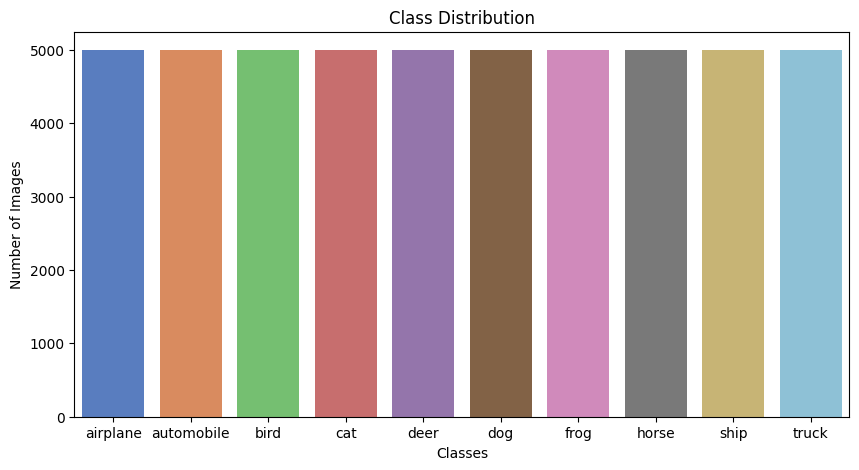

In [62]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=class_df, palette='muted')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [63]:
unique_test, counts_test = np.unique(testY, return_counts=True)
print("\nTest class distribution:")
print(dict(zip(unique_test, counts_test)))


Test class distribution:
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [64]:
class_distribution = dict(zip(unique_test, counts_test))
class_df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Count'])
class_df['Class'] = class_df['Class'].map({k: label_names[k] for k in class_distribution.keys()})

In [65]:
class_df.head(10)

,Class,Count
0,airplane,1000
1,automobile,1000
2,bird,1000
3,cat,1000
4,deer,1000
5,dog,1000
6,frog,1000
7,horse,1000
8,ship,1000
9,truck,1000


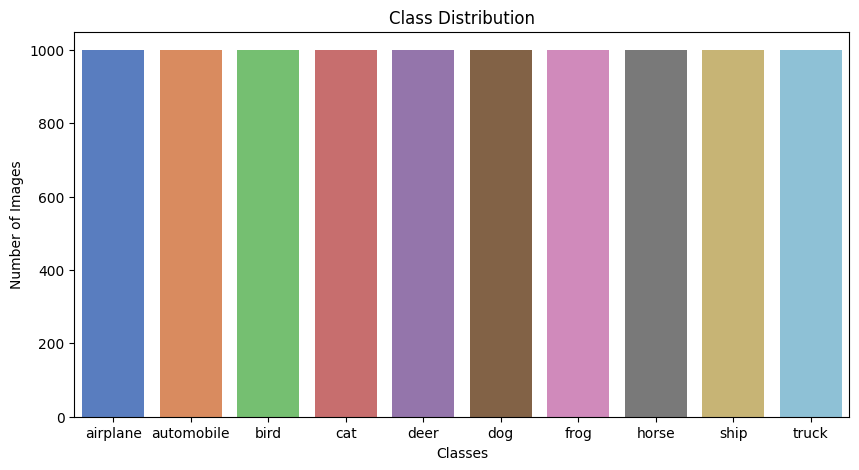

In [66]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=class_df, palette='muted')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [67]:
# basic statistics
print("\nTraining data statistics:")
print("Min pixel value:", np.min(trainX))
print("Max pixel value:", np.max(trainX))
print("Mean pixel value:", np.mean(trainX))
print("Standard deviation of pixel values:", np.std(trainX))


print("\nTesting data statistics:")
print("Min pixel value:", np.min(testX))
print("Max pixel value:", np.max(testX))
print("Mean pixel value:", np.mean(testX))
print("Standard deviation of pixel values:", np.std(testX))


Training data statistics:
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 120.70756512369792
Standard deviation of pixel values: 64.1500758911213

Testing data statistics:
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 121.52915475260417
Standard deviation of pixel values: 64.06097012299574


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i])
    plt.xlabel(label_names[trainY[i][0]])
plt.show()

# Normalize the images

In [69]:
print('Train X value:', trainX[0])
print('Test X value:', testX[0])

Train X value: [[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
Test X value: [[[158 112  49]
  [159 111  47]
  [165 116  51]
  ...
  [137  95  36]
  [126  91  36]
  [116  85  33]]

 [[152 112  51]
  [151 110  40]
  [159 114  45]
  ...
  [136  95  31]
  [125  91  32]
  [119  88  34]]

 [[151 110  47]
  [151 109  33]
  [158 111  36]
  ...
  [139  98  34]
  [130  95  34]
  [120  89  33]]

 ...

 [[ 68 124 177]
  [ 42 

In [70]:
X_train = trainX / 255.0
X_test = testX / 255.0

In [71]:
print('Train X value after normalization:', X_train[0])
print('Test X value after normalization:', X_test[0])

Train X value after normalization: [[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  

# One hot encoding categorical variable

In [72]:
y_train = to_categorical(trainY)
y_test = to_categorical(testY)

In [73]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# K-Nearest Neighbors (KNN)

In [74]:
train_images_flat = X_train.reshape(X_train.shape[0], -1)
test_images_flat = X_test.reshape(X_test.shape[0], -1)

In [75]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_images_flat, trainY)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [76]:
train_predictions= knn_model.predict(train_images_flat)
test_predictions = knn_model.predict(test_images_flat)
accuracy_train = accuracy_score(trainY, train_predictions)
accuracy_test = accuracy_score(testY, test_predictions)
print("Accuray Train set: ", accuracy_train)
print("Accuracy Test Set:", accuracy_test)

Accuray Train set:  0.57904
Accuracy Test Set: 0.3303


In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(testY, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [78]:
model = Sequential([
# Define input layer
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dense(10, activation='softmax'),
])

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# CNN (Convolutional Neural Network)

In [79]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
initial_train_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('initial_modal.h5')

Epoch 1/20
  27/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1208 - loss: 2.3062

W0000 00:00:1713126978.931617      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3365 - loss: 1.7955

W0000 00:00:1713126986.419316      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713126987.388078      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3366 - loss: 1.7954 - val_accuracy: 0.5947 - val_loss: 1.1301
Epoch 2/20
  33/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6095 - loss: 1.1072

W0000 00:00:1713126988.385781      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6173 - loss: 1.0735 - val_accuracy: 0.6812 - val_loss: 0.9004
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7128 - loss: 0.8154 - val_accuracy: 0.7002 - val_loss: 0.8679
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7627 - loss: 0.6768 - val_accuracy: 0.7271 - val_loss: 0.7774
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7993 - loss: 0.5709 - val_accuracy: 0.7454 - val_loss: 0.7800
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8272 - loss: 0.4827 - val_accuracy: 0.7544 - val_loss: 0.7307
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8571 - loss: 0.4058 - val_accuracy: 0.7560 - val_loss: 0.7900
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8797 - loss: 0.3420 - val_accuracy: 0.7444 - val_loss: 0.8669
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8989 - loss: 0.2848 - val_accurac

In [81]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9691 - loss: 0.0907
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7529 - loss: 1.4009
Training Loss: 0.0915602520108223
Training Accuracy: 0.9686599969863892
Test Loss: 1.411534070968628
Test Accuracy: 0.7486000061035156


In [82]:
initial_train_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

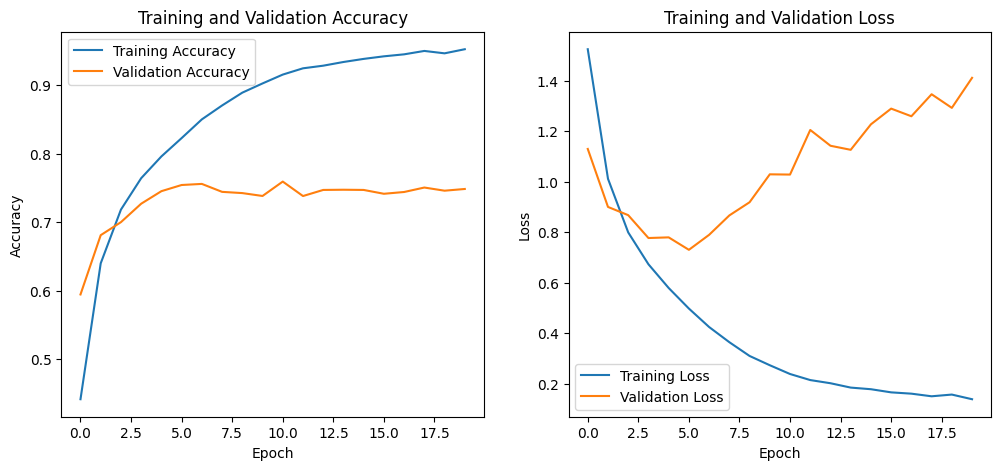

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(initial_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(initial_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(initial_train_history.history['loss'], label='Training Loss')
plt.plot(initial_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

 91/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1713127119.341161      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713127120.163918      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


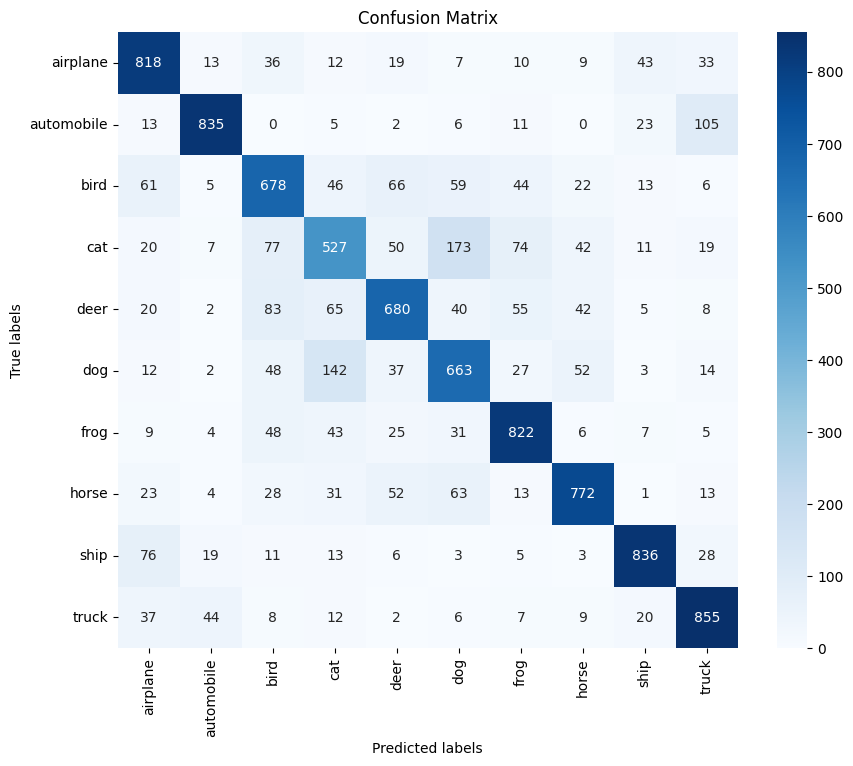

In [84]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Dropout to reduce overfitting

In [85]:
model_batch_dropout = Sequential([
InputLayer(shape=(32, 32, 3)),
Conv2D(32, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D((2, 2)),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(10, activation='softmax'),
])

# compile model
model_batch_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model_batch_dropout.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
batch_dropout_train_history = model_batch_dropout.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('batch_dropout_train_modal.h5')

Epoch 1/20
  50/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1316 - loss: 2.2908    

W0000 00:00:1713127126.123859      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3116 - loss: 1.8600

W0000 00:00:1713127132.103986      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713127133.012409      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3116 - loss: 1.8598 - val_accuracy: 0.5506 - val_loss: 1.2531
Epoch 2/20
  51/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5322 - loss: 1.3101

W0000 00:00:1713127133.801342      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5336 - loss: 1.2956 - val_accuracy: 0.6330 - val_loss: 1.0394
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6114 - loss: 1.1033 - val_accuracy: 0.6609 - val_loss: 0.9656
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6610 - loss: 0.9702 - val_accuracy: 0.7014 - val_loss: 0.8563
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6916 - loss: 0.8909 - val_accuracy: 0.6833 - val_loss: 0.9042
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7154 - loss: 0.8225 - val_accuracy: 0.7257 - val_loss: 0.7922
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7402 - loss: 0.7508 - val_accuracy: 0.7207 - val_loss: 0.8163
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7548 - loss: 0.6983 - val_accuracy: 0.7162 - val_loss: 0.8398
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7673 - loss: 0.6605 - val_accurac

In [88]:
train_loss, train_accuracy = model_batch_dropout.evaluate(X_train, y_train)
test_loss, test_accuracy = model_batch_dropout.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9314 - loss: 0.2038
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7555 - loss: 0.9163
Training Loss: 0.20501631498336792
Training Accuracy: 0.9304199814796448
Test Loss: 0.9381198287010193
Test Accuracy: 0.7491000294685364


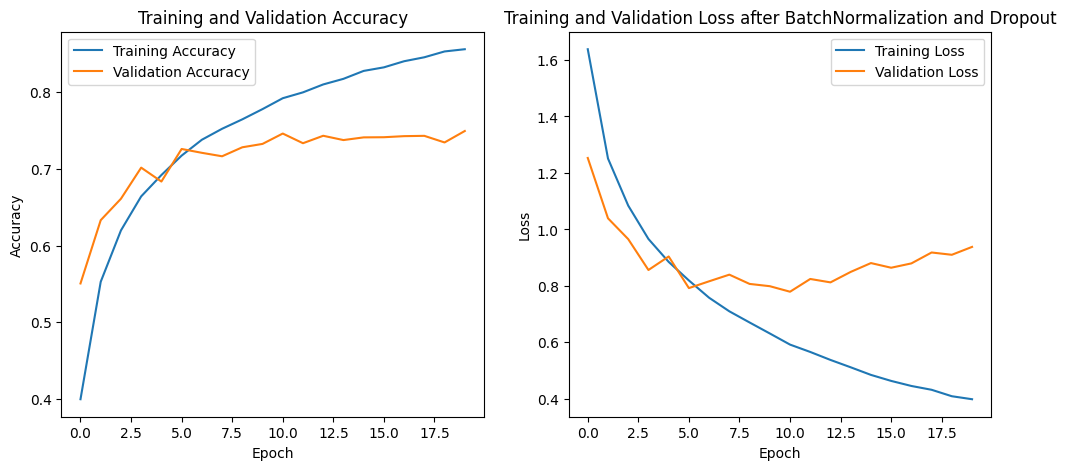

In [89]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_dropout_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(batch_dropout_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_dropout_train_history.history['loss'], label='Training Loss')
plt.plot(batch_dropout_train_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after BatchNormalization and Dropout')
plt.legend()

plt.show()

108/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713127224.022348      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1713127224.707090      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


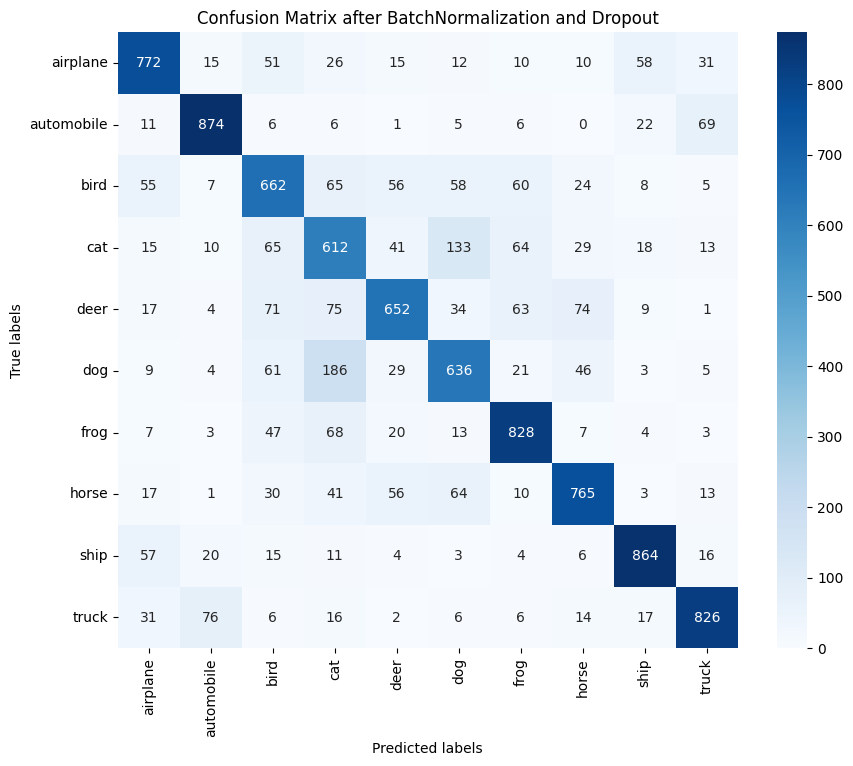

In [90]:
test_predictions = np.argmax(model_batch_dropout.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after BatchNormalization and Dropout")
plt.show()

In [91]:
cnn_with_strides = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(250, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax'),
])

cnn_with_strides.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
cnn_with_strides.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         2,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,245,508 (4.75 MB)

 Trainable params: 1,245,508 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
cnn_with_strides_history = cnn_with_strides.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_with_strides_modal.h5')

Epoch 1/20
  42/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0933 - loss: 2.3374

W0000 00:00:1713127236.961663      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3217 - loss: 1.8209

W0000 00:00:1713127253.488933      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713127254.444597      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.3217 - loss: 1.8207 - val_accuracy: 0.5491 - val_loss: 1.2653
Epoch 2/20
  41/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5166 - loss: 1.3684

W0000 00:00:1713127255.270811      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5587 - loss: 1.2398 - val_accuracy: 0.6301 - val_loss: 1.0307
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6277 - loss: 1.0615 - val_accuracy: 0.6606 - val_loss: 0.9660
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6654 - loss: 0.9600 - val_accuracy: 0.7044 - val_loss: 0.8424
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6952 - loss: 0.8662 - val_accuracy: 0.7118 - val_loss: 0.8179
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7139 - loss: 0.8156 - val_accuracy: 0.7205 - val_loss: 0.7886
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7263 - loss: 0.7849 - val_accuracy: 0.7260 - val_loss: 0.7884
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7433 - loss: 0.7311 - val_accuracy: 0.7452 - val_loss: 0.7297
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7503 - loss: 0.7061 - val_accurac

In [94]:
train_loss, train_accuracy = cnn_with_strides.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn_with_strides.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9156 - loss: 0.2656
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7677 - loss: 0.6865
Training Loss: 0.2645672559738159
Training Accuracy: 0.9164800047874451
Test Loss: 0.6819496750831604
Test Accuracy: 0.7712000012397766


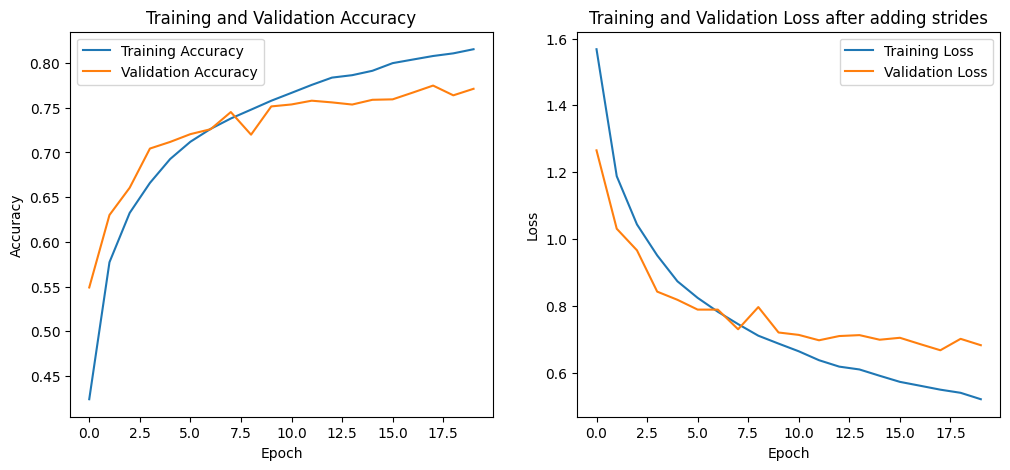

In [95]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_with_strides_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_with_strides_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713127355.986300      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713127356.795431      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


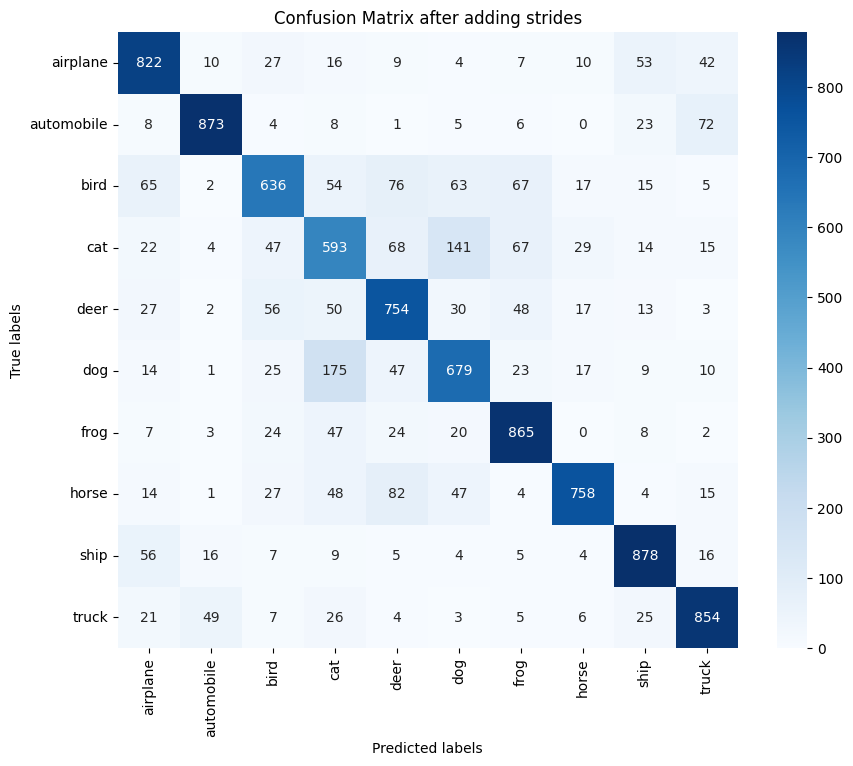

In [96]:
test_predictions = np.argmax(cnn_with_strides.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()

In [97]:
cnn = Sequential([
    InputLayer(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    Conv2D(64, (3, 3), activation='relu',strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 500)            │     1,024,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,618 (5.20 MB)

 Trainable params: 1,362,618 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
cnn_history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

model.save('cnn_modal.h5')

Epoch 1/20
  25/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1106 - loss: 2.3106 

W0000 00:00:1713127367.521060      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2692 - loss: 1.9370

W0000 00:00:1713127380.026550      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713127381.032979      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2693 - loss: 1.9368 - val_accuracy: 0.5121 - val_loss: 1.3234
Epoch 2/20
  31/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4818 - loss: 1.3799

W0000 00:00:1713127382.053853      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5106 - loss: 1.3612 - val_accuracy: 0.5575 - val_loss: 1.2130
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5860 - loss: 1.1699 - val_accuracy: 0.6416 - val_loss: 1.0177
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6247 - loss: 1.0651 - val_accuracy: 0.6375 - val_loss: 1.0189
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6579 - loss: 0.9828 - val_accuracy: 0.6892 - val_loss: 0.8910
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6766 - loss: 0.9248 - val_accuracy: 0.7036 - val_loss: 0.8434
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6993 - loss: 0.8719 - val_accuracy: 0.6949 - val_loss: 0.8958
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7113 - loss: 0.8334 - val_accuracy: 0.7161 - val_loss: 0.8230
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7209 - loss: 0.7925 - val_accura

In [100]:
train_loss, train_accuracy = cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8482 - loss: 0.4315
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7612 - loss: 0.7523
Training Loss: 0.4385450482368469
Training Accuracy: 0.8461400270462036
Test Loss: 0.7541682124137878
Test Accuracy: 0.756600022315979


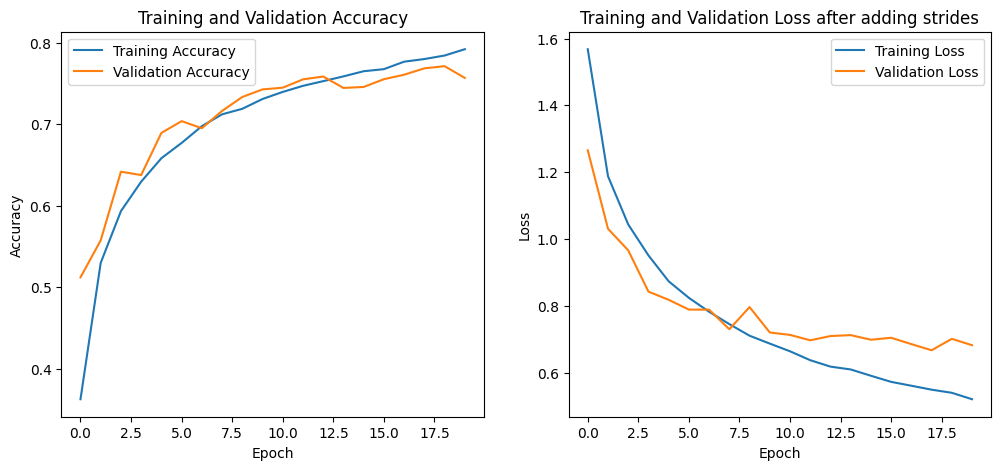

In [101]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss after adding strides')
plt.legend()

plt.show()

In [102]:
cnn = Sequential([
  InputLayer(shape=(32, 32, 3)),
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  Conv2D(32, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25), 
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  Conv2D(64, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.25),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  Conv2D(128, (3, 3), activation='relu', padding='same'),  
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Flatten(),
  Dense(256, activation='relu'),  
  Dropout(0.5), 
  Dense(10, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
 18/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.0983 - loss: 2.3108 

W0000 00:00:1713127536.346792      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2673 - loss: 1.9470

W0000 00:00:1713127546.883577      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713127547.888935      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2674 - loss: 1.9467 - val_accuracy: 0.4885 - val_loss: 1.3819
Epoch 2/100
 17/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4807 - loss: 1.4141

W0000 00:00:1713127548.674176      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5037 - loss: 1.3556 - val_accuracy: 0.6232 - val_loss: 1.0542
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5923 - loss: 1.1455 - val_accuracy: 0.6498 - val_loss: 1.0058
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6456 - loss: 1.0028 - val_accuracy: 0.6995 - val_loss: 0.8494
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6766 - loss: 0.9139 - val_accuracy: 0.7294 - val_loss: 0.7747
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7091 - loss: 0.8332 - val_accuracy: 0.7320 - val_loss: 0.7750
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7209 - loss: 0.7994 - val_accuracy: 0.7538 - val_loss: 0.7153
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7396 - loss: 0.7506 - val_accuracy: 0.7521 - val_loss: 0.7101
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7514 - loss: 0.7084 - val_accuracy: 0.7543

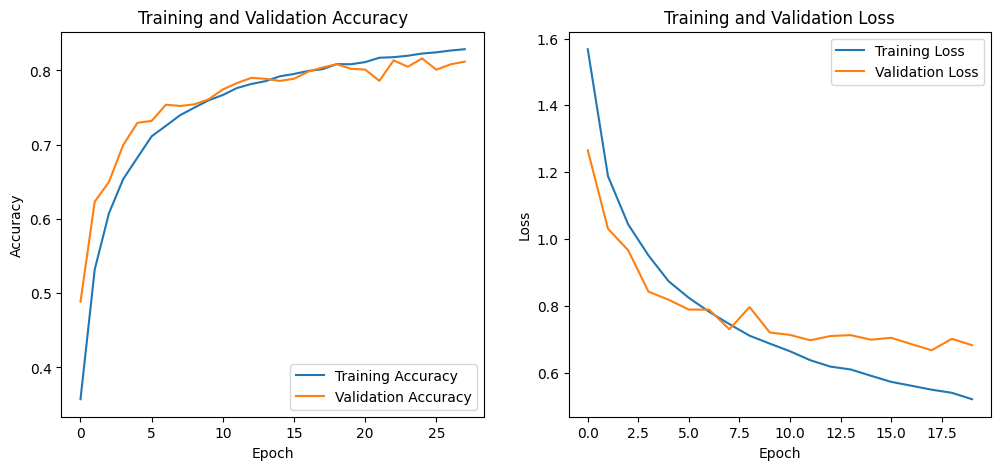

In [103]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_with_strides_history.history['loss'], label='Training Loss')
plt.plot(cnn_with_strides_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [104]:
train_loss, train_accuracy = cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

  65/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9056 - loss: 0.2678

W0000 00:00:1713127697.536855      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9033 - loss: 0.2797
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8186 - loss: 0.5617
Training Loss: 0.2814977467060089
Training Accuracy: 0.9027199745178223
Test Loss: 0.5668847560882568
Test Accuracy: 0.8134999871253967


 96/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1713127702.889856      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713127703.743103      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


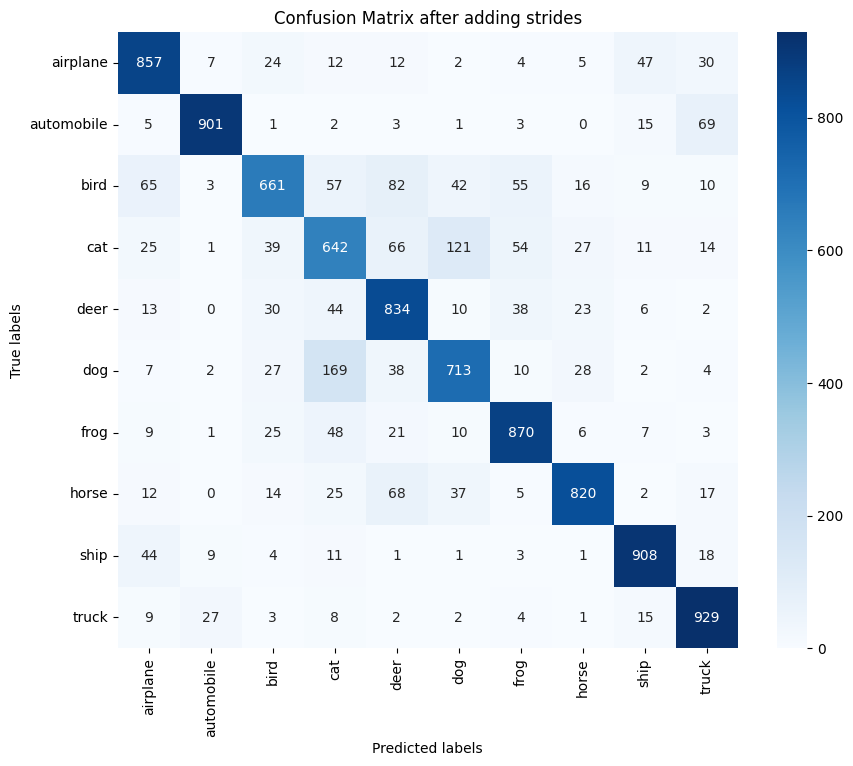

In [105]:
test_predictions = np.argmax(cnn.predict(X_test), axis=-1)
test_true_labels = np.argmax(y_test, axis=-1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(test_true_labels, test_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"], yticklabels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix after adding strides")
plt.show()

In [106]:
model.save('cnn_modal_final.h5')